In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [24]:
data = pd.read_csv('dataset/eth.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,31.Oct.17,307.38,310.55,305.88,305.88,"369,583,008.00","29,331,517,440.00"
1,1.Nov.17,305.76,306.40,290.58,291.69,"553,864,000.00","29,183,592,448.00"
2,2.Nov.17,290.73,293.91,281.17,287.43,"904,900,992.00","27,754,237,952.00"
3,3.Nov.17,288.50,308.31,287.69,305.71,"646,339,968.00","27,547,410,432.00"
4,4.Nov.17,305.48,305.48,295.80,300.47,"416,479,008.00","29,175,347,200.00"


In [25]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [26]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [27]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((283, 50, 1), (31, 50, 1))

In [28]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [29]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Train on 283 samples, validate on 31 samples
Epoch 1/20
283/283 [==============================] - 3s 12ms/step - loss: 0.0984 - val_loss: 0.0010

Epoch 00001: val_loss improved from inf to 0.00102, saving model to ./models/2018_10_31_21_41_26_eth.h5
Epoch 2/20
283/283 [==============================] - 3s 10ms/step - loss: 0.0466 - val_loss: 0.0012

Epoch 00002: val_loss did not improve from 0.00102
Epoch 3/20
283/283 [==============================] - 4s 14ms/step - loss: 0.0377 - val_loss: 0.0019

Epoch 00003: val_loss did not improve from 0.00102
Epoch 4/20
283/283 [==============================] - 5s 17ms/step - loss: 0.0396 - val_loss: 7.9362e-04

Epoch 00004: val_loss improved from 0.00102 to 0.00079, saving model to ./models/2018_10_31_21_41_26_eth.h5
Epoch 5/20
283/283 [==============================] - 5s 18ms/step - loss: 0.0279 - val_loss: 0.0038

Epoch 00005: val_loss did not improve from 0.00079
Epoch 6/20
283/283 [==============================] - 5s 18ms/step - loss: 0

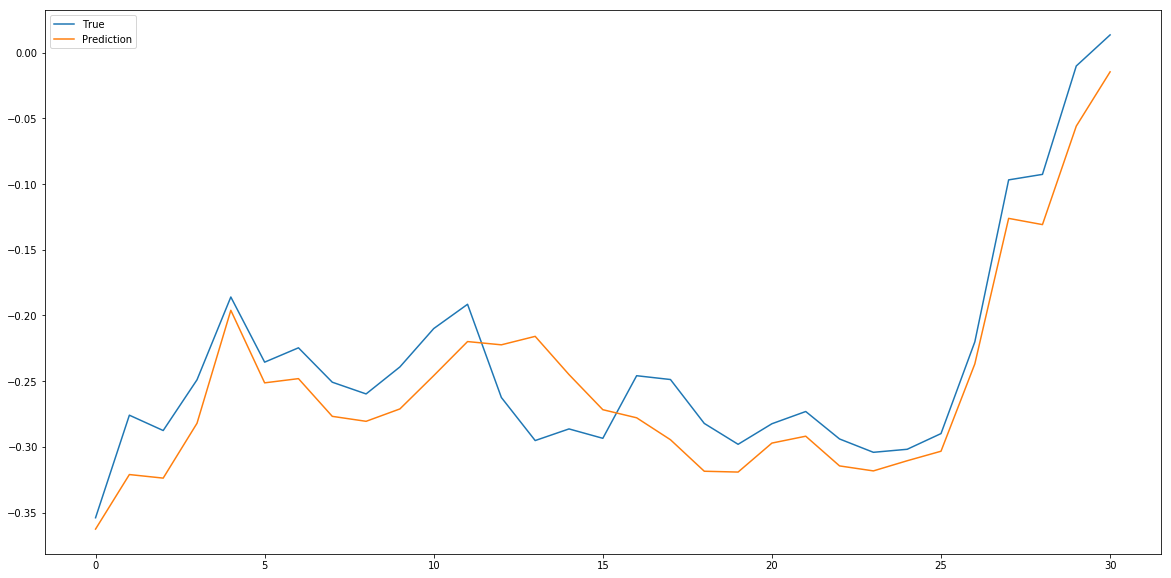

In [30]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()